# FashionMNIST Challenge 大作業

## 作业内容

#### 了解并下载Fashion MNIST数据集（请在github上自行学习数据集的格式以及读取方法），完成相关数据集的预处理工作并使用指定的算法对数据集进行分类或者聚类。具体如下：
1. 将数据集划分成训练集、验证集、测试集并存储成TFRecord文件。
1. 利用matplotlib等工具对TFRecord中的样本数据进行可视化，以验证存储在TFRecord文件中的样本与标记的完整性与对应性，并对数据集有个直观的认识。
1. 设计并训练KNN算法对图片进行分类。
1. 设计并训练K-Means算法对图片进行聚类。
1. 设计并训练NN算法对图片进行分类。
1. 根据你的理解对上述每个算法的运行列出关键公式与步骤简述。

## 代碼實踐

### 一、 将数据集划分成训练集、验证集、测试集并存储成TFRecord文件。

In [3]:
import os
import gzip
import numpy as np
import tensorflow as tf


def load_mnist(path='./data/', kind='train'):
    """
    加載mnist數據集
    :param path: 傳入路徑
    :param kind: 類別(train or t10k)
    :return: 
    """
    labels_path = os.path.join(path, '{0}-labels-idx1-ubyte.gz'.format(kind))
    images_path = os.path.join(path, '{0}-images-idx3-ubyte.gz'.format(kind))

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 784)

    return images, labels


# img, lab = load_mnist(path='./data/')
# print(img)
# print(lab)


In [2]:
# 發現 tensorflow 自帶了讀取 mnist格式的模塊,直接調用好啦٩(｡・ω・｡)و


from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('./data/',validation_size=5000)


# print(data)
# print(len(data.train.next_batch(60000)[0]))
# print(len(data.validation.next_batch(10000)[0]))
# print(len(data.test.next_batch(10000)[0]))

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


In [3]:
from PIL import Image
# imgs, labs = load_mnist()

def write_tfrecord(lable,data):
    writer = tf.python_io.TFRecordWriter(lable+".tfrecords")
    num=len(data.labels)
    for i in range(num):
        if (i+1) % 10000==0:
            print("以處理{0}數據集{1}張".format(lable,i+1))
        img=data.images[i]
        example = tf.train.Example(features=tf.train.Features(feature={
            "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[data.labels[i]])),
            'img_val': tf.train.Feature(float_list=tf.train.FloatList(value=[img][0]))
        }))  # example對象 對label及img_val 進行封裝
        writer.write(example.SerializeToString())  # 序列化字符串?
        i += 1
    print("{0}數據集處理完成".format(lable))
    writer.close()

write_tfrecord("train",data.train)
write_tfrecord("validation",data.validation)
write_tfrecord("test",data.test)


以處理train數據集10000張
以處理train數據集20000張
以處理train數據集30000張
以處理train數據集40000張
以處理train數據集50000張
train數據集處理完成
validation數據集處理完成
以處理test數據集10000張
test數據集處理完成


### 二、利用matplotlib等工具对TFRecord中的样本数据进行可视化，以验证存储在TFRecord文件中的样本与标记的完整性与对应性，并对数据集有个直观的认识。

Tensor("Cast_2:0", shape=(28, 28), dtype=float64)
Tensor("Cast_3:0", shape=(), dtype=int32)


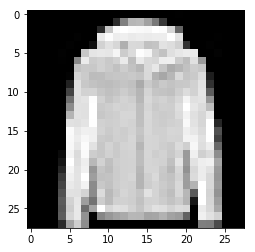

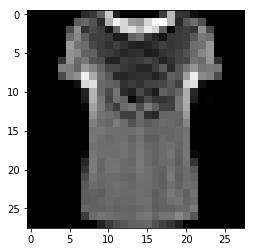

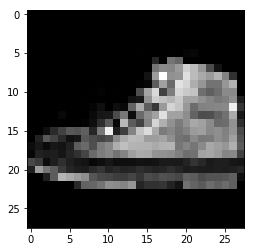

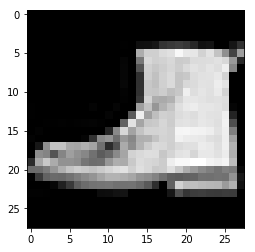

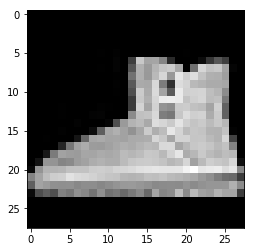

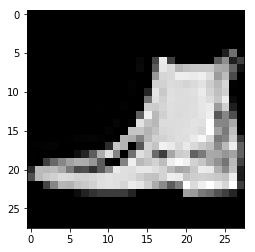

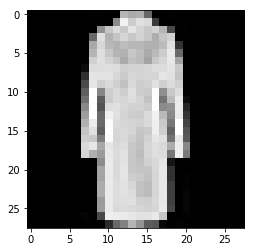

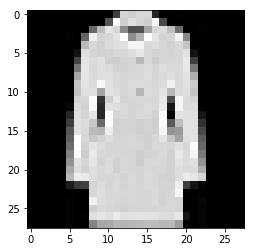

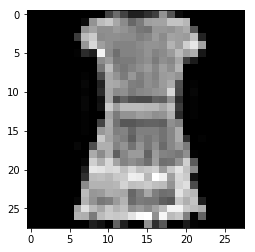

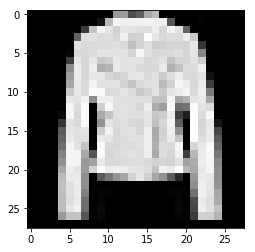

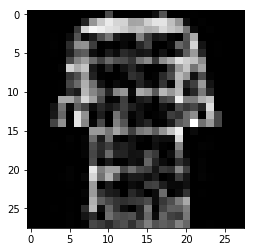

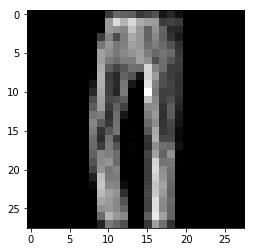

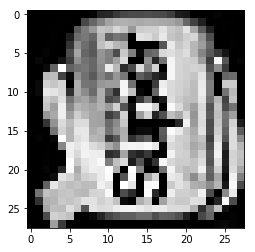

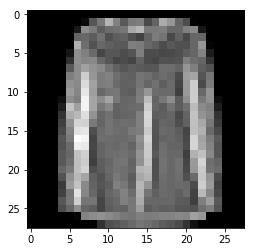

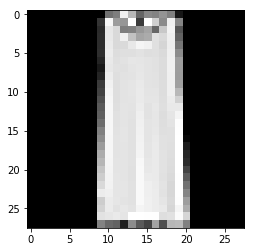

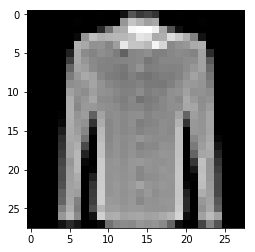

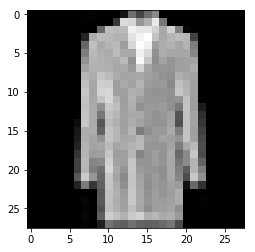

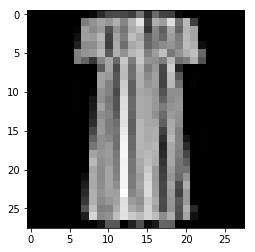

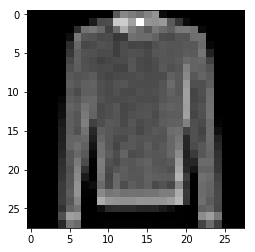

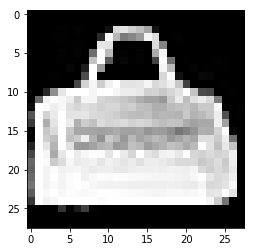

In [5]:
# 將製作好的 tfrecord 數據集文件讀取出來,並轉換成圖片,以驗證數據是否準確無誤
from PIL import Image
filename_queue = tf.train.string_input_producer(["train.tfrecords"]) #读入流中
reader = tf.TFRecordReader()
_, serialized_example = reader.read(filename_queue)   #返回文件名和文件
features = tf.parse_single_example(serialized_example,
                                   features={
                                       'label': tf.FixedLenFeature([], tf.int64),
                                       'img_val' : tf.FixedLenFeature([28,28], tf.float32),
                                   })  #取出包含image和label的feature对象
image = tf.cast(features['img_val'], tf.float64)
# image = tf.reshape(image, [28, 28])
label = tf.cast(features['label'], tf.int32)

print(image)
print(label)


import matplotlib.pyplot as plt
% matplotlib inline 


with tf.Session() as sess: # 開始一個對話
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    coord=tf.train.Coordinator()
    threads= tf.train.start_queue_runners(coord=coord)
    for i in range(20):
        example, l = sess.run([image,label]) # 在會話中取出image和label數據
        example*=255
        # print(example)
        # example=tf.reshape(example,[28,28])
        # example=example.reshape(28,28)
        img=Image.fromarray(example)
        plt.imshow(img)
        plt.show(img)
        example = np.array(example, dtype='uint8')
        img=Image.fromarray(example)
        img.save(str(i)+'_''Label_'+str(l)+'.bmp','bmp')# 保存圖
        # print(example, l)
    coord.request_stop()
    coord.join(threads)


嗯,就醬,matplotlib配置有問題,直接保存在本地了
<img src="img/srecc.png">

### 三、设计并训练KNN算法对图片进行分类。

In [3]:
import numpy as np
import tensorflow as tf


def loadMNIST():
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets('./data/', one_hot=True)
    return mnist

def read_tfrecord(filename,tensor=[1,784],num=5000):
    filename_queue = tf.train.string_input_producer([filename]) #读入流中
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)   #返回文件名和文件
    features = tf.parse_single_example(serialized_example,
                                       features={
                                           'label': tf.FixedLenFeature([], tf.int64),
                                           'img_val' : tf.FixedLenFeature(tensor, tf.float32),
                                       })  #取出包含image和label的feature对象
    image = tf.cast(features['img_val'], tf.float64)
    label = tf.cast(features['label'], tf.int32)
    images=[];labels=[]
    with tf.Session() as sess:
        init_op = tf.global_variables_initializer()
        sess.run(init_op)
        coord=tf.train.Coordinator()
        threads= tf.train.start_queue_runners(coord=coord)
        for i in range(num):
            example, l = sess.run([image, label])
            images.append(np.array(example[0]))
            tem=np.zeros((1,10))
            tem[0][l]=1.0
            labels.append(tem[0])
            del tem
        coord.request_stop()
        coord.join(threads=threads)
    images=np.array(images)
    labels=np.array(labels)
    return images,labels


# img,lab=read_tfrecord(filename='test.tfrecords',tensor=[28,28],num=50)
# print(img)
# print(lab)


def KNN():
#     train_x, train_y = mnist.train.next_batch(60000)
#     test_x, test_y = mnist.test.next_batch(5000)
    train_x,train_y=read_tfrecord(filename='train.tfrecords',tensor=[1,784],num=60000)
    test_x, test_y =read_tfrecord(filename='test.tfrecords',tensor=[1,784],num=5000)
    # 數據二值化處理
    for i in range(len(train_x)):
        for j in range(len(train_x[0])):
            if train_x[i][j]>0:
                train_x[i][j]=1.0
    print(train_x[0])
    for i in range(len(test_x)):
        for j in range(len(test_x[0])):
            if test_x[i][j] > 0:
                test_x[i][j] = 1.0
    xtr = tf.placeholder(tf.float32, [None, 784])
    xte = tf.placeholder(tf.float32, [784])
    distance = tf.sqrt(tf.reduce_sum(tf.pow(tf.add(xtr, tf.negative(xte)), 2), reduction_indices=1))

    pred = tf.argmin(distance, 0)

    init = tf.global_variables_initializer()

    sess = tf.Session()
    sess.run(init)

    right = 0
    for i in range(250):
        if i % 50==0 and i !=0:
            print("已处理 {0}，正确率为{1}".format(i,right/i))
        ansIndex = sess.run(pred, {xtr: train_x, xte: test_x[i, :]})
        # print('prediction is ', str(np.where(train_y[ansIndex]==np.max(train_y[ansIndex]))))
        # print('true value is ', str(np.where(test_y[i]==np.max(test_y[i]))))
        if np.argmax(test_y[i]) == np.argmax(train_y[ansIndex]):
            right += 1.0
    accracy = right / 250.0
    print(accracy)


if __name__ == "__main__":
#     mnist = loadMNIST()
    KNN()

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1

In [14]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline 
from sklearn.manifold import TSNE
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('./data/', one_hot=True)
X_embedded = TSNE(n_components=2).fit_transform(mnist.train.next_batch(10000)[0])
print(X_embedded)
np.random.rand(2,n)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
[[-47.57136536   5.11488485]
 [-27.06114197  28.17174911]
 [ 19.26391983  16.22604561]
 ..., 
 [-34.11985016 -46.65794373]
 [ -6.53253174  29.47970581]
 [ 34.45330429  11.88749313]]


NameError: name 'n' is not defined

###  四、设计并训练K-Means算法对图片进行聚类。